# LDE Lab 2: Spreading on Networks

AIM:

- Create two networks of size N = 1000 and similar degree:
    - A Erdös and Rényi random graph 
    - A Barabasi-Albert Scale-free network   

- Adapt the SIR and SIS dynamics to include the network structure
- Write a code that iterates over values of beta and create the epidemic diagram for the two networks




In [1]:
import random
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

N = int(1e3); p = 0.5
beta = 0.001 # infection probability
mu = 0.2 # recovery probability

## Create an ER graph 

In [23]:
def er(N,p):
    '''
    This function creates a N,p Erdös and Rényi graph 
    
    Arguments:
    
    1) N: number of nodes in the graph
    
    2) p: connection probability for each couple of nodes 
    
    Output: 
    
    a networkx graph contaning the network
    
    '''
    
    'Creates an empty graph'
    G = nx.Graph()
    
    'adds N nodes'
    G.add_nodes_from(range(N))
    
    edges = set()
    
    for i in range(N):
        
        for j in range(N):
            
            if i != j:
            
                if random.random() < p:
                
                    edges.add((i,j))
    
    G.add_edges_from(edges)
    #nx.draw(G) 
    return G
                    
            

## Barabasi-Albert scale-free network 

In [3]:
def ba(N,m):
    '''
    This function creates a Scale-free network employing the Barabasi-Albert algorithm  
    
    Arguments:
    
    1) N: number of nodes in the graph
        
    2) m: number of links to be added at each time
    
    Output: 
    
    a networkx graph contaning the network
    
    '''
    
    'Creates an empty graph'
    G = nx.Graph()
    
    'size of the initial clique of the network'
    m0= 4
    
    'adds the m0 initial nodes'
    G.add_nodes_from(range(m0))
    
    'creates an empty list to store all the new edges of the network to be added later.' 
    edges = []
    
    'creates the initial clique connecting all the m0 nodes'
    for i in range(m0):
        
        for j in range(i,m0):
                            
                if i != j:
                
                    edges.append((i,j))
    
    'adds the initial clique to the network'
    G.add_edges_from(edges)
    
    
    'list to store the nodes to be selected for the preferential attachment.'
    'instead of calculating the probability of being selected a trick is used: if a node has degree k, it will appear'
    'k times in the list. This is equivalent to select them according to their probability.'
    prob = []
    
    'runs over all the reamining nodes'
    for i in range(m0,N):
        G.add_node(i)
        'for each new node, creates m new links'
        for j in range(m):
            
            'creates the list of nodes'
            for k in list(G.nodes):
                
                'each node is added to the list according to its degree'
                for z in range(nx.degree(G,k)):
                
                    prob.append(k)
            'picks up a random node, so nodes will be selected proportionally to their degree'
            node = random.choice(prob)
            
            
            
            G.add_edge(node,i)
        
            'the list must be created from 0 for every link since with every new link probabilities change'
            prob.clear()
            #nx.draw(G) 
    'returns the graph'
    return G
                    
            

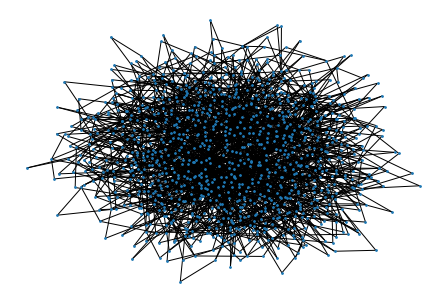

In [4]:
'Creates a ER graph and a BA network both with N nodes'

N= int(1e3)

'For the ER graph, p must be such as <k> ~ 6,8'
#Ger = er(N,1)
#nx.draw_circular(Ger, with_labels=True)

'For the BA network, two links per node are added'
Gba = ba(N,2)

nx.draw(Gba, with_labels=False, node_size = 3)

# SIR dynamics

In [34]:
def sir(G,beta,mu, flag):
    '''
    This function simulates a SIR process 
    
    Arguments:
    
    1) G: the graph on which run the dynamics
    
    2) beta: per-contact probability to transmit the disease from an infected individual to a susceptible one 
    during a single time step 
    
    3) mu: probability to become recovered during a single time step
    
    4) K: number of contacts per time-step
    
    Output:
    
    a list containing the prevalence during each time step
    
    '''
    
    'Number of nodes in the graph'
    N=G.number_of_nodes()
    
    'Creates the labels for all the individuals'
    node_labels = G.nodes()
    
    'Creates an empty list to store currently infected individuals' 
    inf_list = [] 
    fr_stinf = 10/N
    
    'Creates an empty list to store the time evolution of the infected and the recovered' 
    susceptible = [1-fr_stinf]
    prevalence = [fr_stinf]
    recovered = [0]
    totcases = [fr_stinf]

    dni = [0]
    dni_totcases = [fr_stinf]
    dni_susceptible = [1-fr_stinf]


    'Sets the current and future state to S for all the individuals'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    'Selects the seed of the disease'
    #my_comment: If k != 1, random.choice would take the same node, since it's "with replacement". So, use random.sample(range(N), k = 3)
    #random.seed(0)
    seeds = random.sample(range(N), k = 10) 

    for seed in seeds:
        'Sets the status of the seed to I'
        current_state[seed] = 'I'
        future_state[seed] = 'I'
        
        'Adds the seed to the infected list'
        inf_list.append(seed)
    
   
    'Temporal evolution of the dynamics, runs until there are no infected '
    while(len(inf_list)>0): 

        daily_new_inf = 0
        
        'Infection Phase: each infected picks K individuals at random and tries to infect them'        
        for i in inf_list:
            
            'Select the neighbors of the infected node'
            tests = G.neighbors(i)
            
            for j in tests:

                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    
                    if random.random() < beta:
                        
                        'IMPORTANT: the status is checked on the current state but updated in the future state'
                        future_state[j] = 'I'
                        daily_new_inf += 1

                    else:
                        
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            
            'Also the recovery takes place in the future state'
            if random.random() < mu:
                
                future_state[i] = 'R'
    
            else:
                 
                future_state[i] = 'I'
                
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy()
       
        'Updates inf_list with the currently infected' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'    
        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))
        susceptible.append(1-prevalence[-1]-recovered[-1])

        dni.append(daily_new_inf/float(N))        
        dni_totcases.append(dni_totcases[-1]+daily_new_inf/float(N))            
        totcases.append(totcases[-1]+prevalence[-1]-prevalence[-2]+recovered[-1]-recovered[-2])
        dni_susceptible.append(1-dni_totcases[-1])

        'Find <D>, \lambda: R(t) - D + \lambda^-1 > 0 --> t = t - 1/mu, Dc = R(t)+\lambda^-1'    
        '''if flag and len(recovered) > 1:
            D = sum([j for _,j in G.degree()]) / N
            mbeta = mu/beta
            if recovered[-1]*N - D + mbeta  >= 0:
                t_c = len(recovered) - 1/mu
                D_c = recovered[-2]*N + mbeta
                flag = False
            else: t_c, D_c = 0, 0'''

            
        if len(dni_susceptible) > 1 and flag:
            D = sum([j for _,j in G.degree()]) / N
            D2 = sum([j**2 for _,j in G.degree()]) / N
            R_0net = D**2/(D2-D)
            Rmbeta = mu/beta * R_0net
            y_c = Rmbeta / D
            #print(susceptible[-2], y_c, susceptible[-1])
            if dni_susceptible[-1] <=  y_c <= dni_susceptible[-2]:
                print("limit", Rmbeta/D)
                y1 = dni_susceptible[-1]; x1 = len(dni_susceptible) - 1 
                dy = y1 - dni_susceptible[-2]; dt = 1
                m = dy/dt
                t_c =  1/m * (y_c - y1) + x1
                flag = False
                print(dni_susceptible[-2], dni_susceptible[-1], y_c, x1)
            else: t_c, D_c = 0, 0


    return susceptible, prevalence, recovered, dni, totcases, dni_totcases, dni_susceptible, t_c, y_c, R_0net, D
        

In [ ]:
def my_new_sir(G, flag, mf = False, beta = 1e-3, mu = 0.05, seed = False):
  #this is the regular sir
  'If mf == False, the neighbors are not fixed;' 
  'If mf == True, std mf by choosing @ rnd the num of neighbors'

  import random
  #here's the modifications of the "test_ver1"
  'Number of nodes in the graph'
  N, mean, _ = N_D_std_D(G)

  'Label the idnividual wrt to the # of the node'
  node_labels = G.nodes()
  
  'Currently infected idnividuals and the future infected and recovered' 
  susceptible = [1-0.01]
  prevalence = [0.01]
  recovered = [0]
  totcases = [0.01]

  inf_list = [] #infected node list @ each t

  dni = [] # = len(inf_list)/N, i.e. frac of daily infected for every t
  cum_dni = [0.01]
  arr_dni = [] #arr to computer Std(daily_new_inf(t)) for daily_new_inf(t)!=0

  'Initial Codnitions'
  current_state = ['S' for i in node_labels] 
  future_state = ['S' for i in node_labels]
  
  if seed: 
    random.seed(0)

  'Selects the seed of the disease'
  inf_list = random.sample(node_labels, start_inf)

  inf_list = random.sample(node_labels, start_inf)  #without replacement, i.e. not duplicates
  if rhu(mean,0)-1 <= 0 and mf: #too slow for D = 1
    inf_list = []
  for seed in inf_list:
    current_state[seed] = 'I'
    future_state[seed] = 'I'

  'initilize dni (new daily infected) and recovered list'
  'we dont track infected'
  dni = [0] #[len(inf_list)/N] 
  recovered = [0]
  cum_dni = [start_inf/N]
  num_susc = [N-start_inf]

  'start and continue whenever there s 1 infected'
  while(len(inf_list)>0):        
    daily_new_inf = 0
    'Infection Phase: inf_list = prev_time infecteds'
    'each infected tries to infect all of the neighbors'
    for i in inf_list:
        'Select the neighbors of the infected node'
        if not mf: tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
        if mf: 
          ls = list(range(N)); ls.remove(i)
          tests = random.sample(ls, k = int(rhu(mean))) #spread very fast since multiple infected center
        tests = [int(x) for x in tests] #convert 35.0 into int
        for j in tests:
          if current_state[j] == 'S' and future_state[j] == 'S' and random.random() < beta:
            future_state[j] = 'I'; daily_new_inf += 1
    
    if daily_new_inf != 0: arr_dni = arr_dni+[daily_new_inf]

    'Recovery Phase: only the prev inf nodes (=inf_list) recovers with probability mu'
    'not the new infected'    
    'This part is important in the OrderPar since diminishes the inf_list # that is in the "while-loop"'    
    for i in inf_list:
      if random.random() < mu:
          future_state[i] = 'R'
      else:
          future_state[i] = 'I'
    
    'Time update: once infections and recovery ended, we move to the next time-step'
    'The future state becomes the current one'
    current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
    
    'Updates inf_list with the currently fraction of inf/rec and save lenS to avg_R' 

    #IDEA: this is = to take the index on "current_state"
    inf_list = [i for i, x in enumerate(current_state) if x == 'I']
    rec_list = [i for i, x in enumerate(current_state) if x == 'R']

    'Saves the fraction of new daily infected (dni) and recovered in the current time-step'
    prevalence.append(len(inf_list)/float(N))
    recovered.append(len(rec_list)/float(N))
    susceptible.append(1-prevalence[-1]-recovered[-1])
    
    dni.append(daily_new_inf/float(N))
    total_dni.append(total_dni[-1]+daily_new_inf/N) 
    totcases.append(totcases[-1]+prevalence[-1]-prevalence[-2]+recovered[-1]-recovered[-2])

 
    #loop +=1;
    #print("loop:", loop, cum_total_inf, cum_total_inf[-1], daily_new_inf/N)

    #print("\nnum_susc, dni, recovered",num_susc, dni, recovered, 
    #len(num_susc), len(dni), len(recovered))
  
  'Order Parameter (op) = Std(Avg_dni(t)) s.t. dni(t)!=0 as a func of D'
  if not mf:
    ddof = 0
    if len(arr_dni) > 1: ddof = 1
    if arr_dni == []: arr_dni = [0]
    oneit_avg_dni = np.mean(arr_dni)
    'op = std_dni'
    op = np.std( arr_dni, ddof = ddof )
    if len(arr_dni) > 1:
      if len([x for x in arr_dni if x == 0]) > 0: 
        raise Exception("Error There's 0 dni: dni, arr_daily, std", daily_new_inf, arr_dni, op)

    'oneit_avg_R is the mean over the time of 1 sir. Then, avg over-all iterations'
    'Then, compute std_avg_R'
    degrees = [j for _,j in G.degree()]
    D = np.mean(degrees)
    #print("R0, b,m,D", beta*D/mu, beta, mu, D)
    c = beta*D/(mu*num_susc[0])
    oneit_avg_R = c*np.mean(num_susc)
    ddof = 0
    if len(num_susc) > 1: ddof = 1
    std_oneit_avg_R = c*np.std(num_susc, ddof = 1)
    #print("num_su[0], np.sum(num_susc), len(prev), oneit_avg_R2", \
    #  num_susc[0],np.sum(num_susc), len(dni), oneit_avg_R)

    #return oneit_avg_R, std_oneit_avg_R, oneit_avg_dni, op, dni, cum_dni
    return oneit_avg_dni, op, dni, cum_dni
  

  if len(susceptible) > 1 and flag:
    D = sum([j for _,j in G.degree()]) / N
    D2 = sum([j**2 for _,j in G.degree()]) / N
    R_0net = D**2/(D2-D)
    Rmbeta = mu/beta * R_0net
    y_c = Rmbeta / D
    #print(susceptible[-2], y_c, susceptible[-1])
    if susceptible[-1] <=  y_c <= susceptible[-2]:
      print("limit", Rmbeta/D)
      y1 = susceptible[-1]; x1 = len(susceptible) - 1 
      dy = y1 - susceptible[-2]; dt = 1
      m = dy/dt
      t_c =  1/m * (y_c - y1) + x1
      flag = False
      print(susceptible[-2], susceptible[-1], y_c, x1)
    else: t_c, D_c = 0, 0


  return susceptible, prevalence, recovered, dni, totcases, total_dni, t_c, y_c, R_0net, D

limit 0.10000695044333899
0.15799999999999992 0.04899999999999993 0.10000695044333899 7
t_c, yc, t'c, R_0tmax for er_graph_sir 6.532046326207898 0.10000695044333899 1.5320463262078983 1.5913759999999992 0.49352799999999986


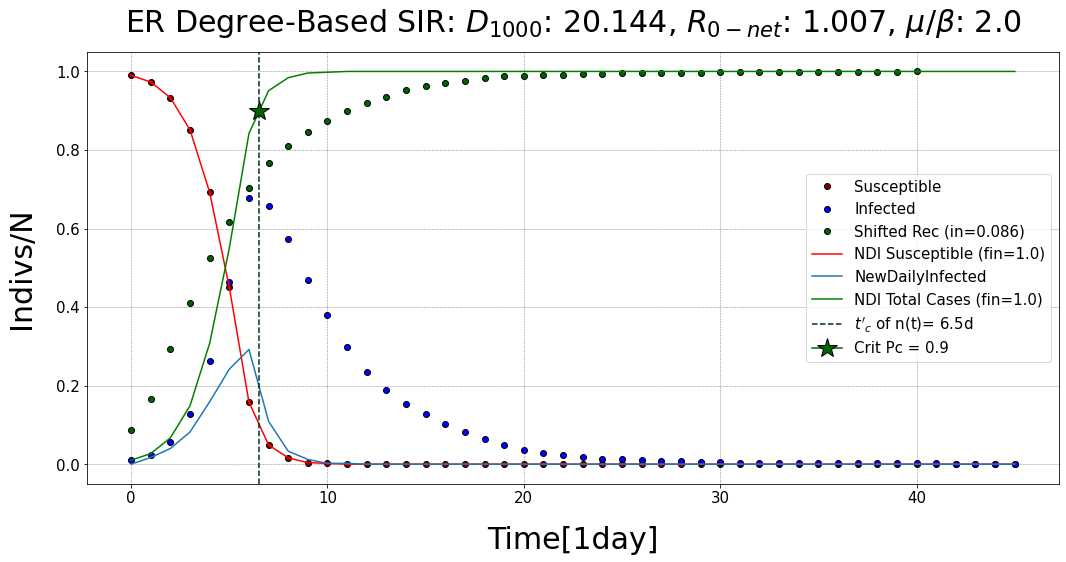

limit 0.0020040080160320644
0.33799999999999997 0.0 0.0020040080160320644 2
t_c, yc, t'c, R_0tmax for complete_graph_sir 1.9940709822010885 0.0020040080160320644 -3.0059290177989118 1.3863910020006642e-14 2.7727820040013285e-14


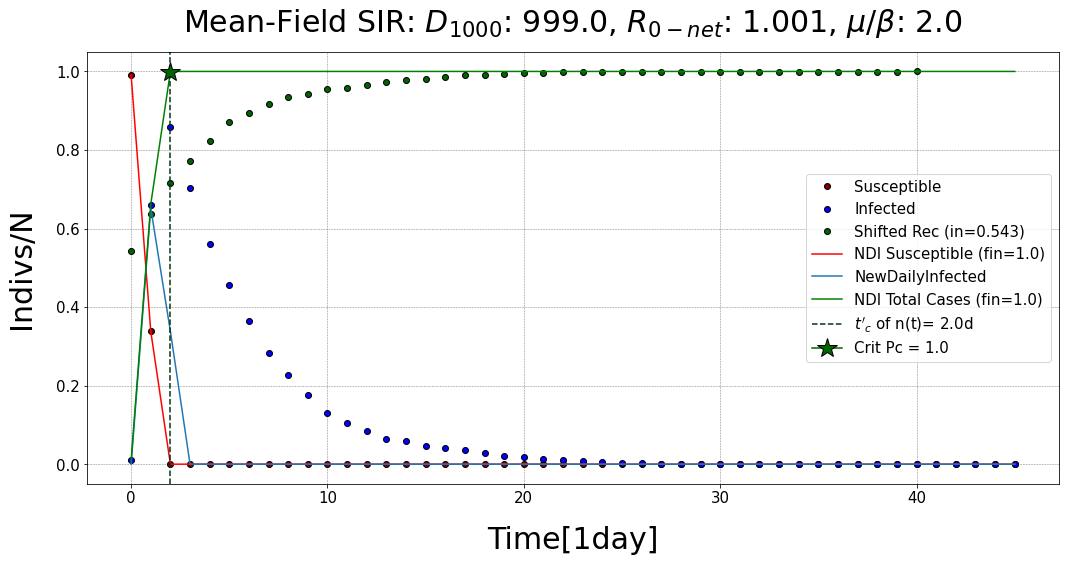

t_c, yc, t'c, R_0tmax for er_graph_sir 0 0.3996003996003996 -5.0 2.7689999999999997 2.766


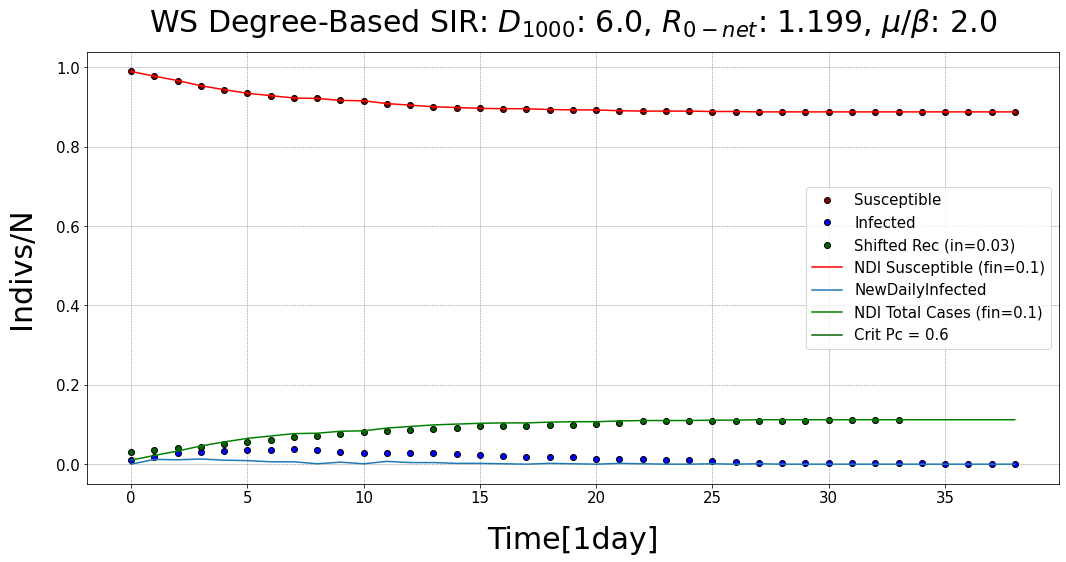

In [35]:
def rhu(n, decimals=1, integer = False): #round_half_up
    import math
    multiplier = 10 ** decimals
    res = math.floor(n*multiplier + 0.5) / multiplier
    if integer: return int(res)
    return res

#Set the plot parameters
def plot_params(plt_title):
  plt.figure(figsize = (15,8))
  plt.xlabel('Time[1day]', fontsize = 30, labelpad = 20)
  plt.xticks(fontsize = 15)
  plt.yticks(fontsize = 15)
  plt.ylabel('Indivs/N', fontsize = 30, labelpad = 20)
  plt.grid(color='grey', linestyle='--', linewidth = 0.5)
  #plt.tick_labels(axis='both', which='major', pad=15)
  plt.subplots_adjust(
    top=0.9,
    bottom=0.15,  #0.088
    left=0.08,
    right=0.98)
  plt.title(f"{plt_title}", fontsize = 30, pad = 20)


def plot_sir(G,beta,mu, fig_name, plt_title):
  import numpy as np
  
  plot_params(plt_title)  

  flag = True
  susceptible, prevalence, recovered, dni, totcases, dni_totcases, dni_susceptible, t_c, y_c, R_0net, D = sir(G, beta, mu, flag)
  t_max = np.argmax(prevalence)
  R_0tmax = ( D * susceptible[t_max] ) * beta/mu
  tp_c = t_c - 1/mu
  print(f"t_c, yc, t'c, R_0tmax for {fig_name}", t_c, y_c, tp_c, R_0tmax, ( D * susceptible[t_max+1] ) * beta/mu
  )
  plt.plot(susceptible, label = "Susceptible", color = "maroon", marker = "o", mec = "black", lw = 0)
  plt.plot(prevalence, label = "Infected", color = "blue", marker = "o", lw = 0, mec = "k")
  plt.plot(recovered[int(1/mu):], label = f"Shifted Rec (in={recovered[int(1/mu)]})", color = "darkgreen", marker = "o", mec = "black", linestyle = "none")
  
  plt.plot(dni_susceptible, label = f"NDI Susceptible (fin={rhu(dni_totcases[-1])})", color = "red")
  plt.plot(dni, label = f"NewDailyInfected", color = "tab:blue")
  plt.plot(dni_totcases, label = f"NDI Total Cases (fin={rhu(dni_totcases[-1])})", color = "green",)# marker = "o", linestyle = "none")
  
  
  #if t_c > 0: plt.axvline(t_c, color = "blue", linestyle = "dotted", label = rf"$t_c = {rhu(t_c)}d \, of \, P(t)$")
  if t_c > 0: 
    plt.axvline(t_c, color = "#003312", linestyle = "dashed", label = r"$t_c$ of P(t)" + f"= {rhu(t_c)}d")
    plt.plot(t_c, 1-y_c, color = "darkgreen", marker = "*", mec = "k", markersize = 20, label = f"Crit Pc = {rhu(1-y_c,2)}")
  else: 
    plt.plot(0, color = "darkgreen", marker = "*", markersize = 0, label = f"Crit Pc = {rhu(1-y_c,2)}")

  #if t_max > 0: 
  #  plt.axvline(t_max, color = "midnightblue", linestyle = "dashdot", label = r"$t_{MAX}$" + f"= {t_max}d")
    #if susceptible[t_max] > 0: plt.plot(t_max, susceptible[t_max], color = "maroon", marker = "*", markersize = 20, label = f"Suscep_tmax= {rhu     (susceptible[t_max],3)}")

  plt.title("".join((f"{plt_title}",
                    r": $D_{%s}$: %s" % (N, D) ,
                    r", $R_{0-net}$", f": {rhu(R_0net,3)}",
                    r", $\mu/ \beta$",f": {rhu(mu/beta,1)}"
                    ))
            , fontsize = 30, pad = 20)

  plt.legend(prop={'size': 15}, loc = "best")
  plt.show()
  #plt.savefig(f"{fig_name}.jpg", format="jpg", dpi=200)
  plt.close()


N = int(1e3)
beta = 0.1 # infection probability
mu = 0.2 # recovery probability

# simulate SIR dynamics and obtain prevalence
p = 0.02 #really good graph for beta, mu, p, N = 0.1, 0.2, 0.02, 1000
G=nx.erdos_renyi_graph(N,p)
plot_sir(G,beta,mu,"er_graph_sir","ER Degree-Based SIR")

# simulate SIR dynamics and obtain prevalence
G = nx.complete_graph(N) # graph
plot_sir(G,beta,mu,"complete_graph_sir","Mean-Field SIR")

# simulate SIR dynamics and obtain prevalence
D = 6; p = 0.004
G=nx.connected_watts_strogatz_graph(N,D,p)
plot_sir(G,beta,mu,"er_graph_sir","WS Degree-Based SIR")

# "My_SIR" Simulation

In [15]:
def my_sir(G, beta, mu, k = 1):
    'Number of nodes in the graph'
    N = G.number_of_nodes()
    
    'Label the individual wrt to the # of the node'
    node_labels = G.nodes()
    
    'Currently infected individuals and the future infected and recovered' 
    inf_list = [] 
    prevalence = []
    recovered = []

    'Initial Conditions'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    random.seed(0)

    'Selects the seed of the disease'
    seeds = random.sample(range(N), k) 
    for seed in seeds:
      current_state[seed] = 'I'
      future_state[seed] = 'I'
      inf_list.append(seed)

    
    prevalence = [len(inf_list)/N]

    while(len(inf_list)>0):        
        
        'Infection Phase: each infected tries to infect all of the neighbors'
        for i in inf_list:
            'Select the neighbors of the infected node'
            tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
            for j in tests:
                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    if random.random() < beta:
                        future_state[j] = 'I'
                    else:
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            if random.random() < mu:
                future_state[i] = 'R'
            else:
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
       
        'Updates inf_list with the currently fraction of inf/rec' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'

        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))
 
    return prevalence, recovered

In [13]:
my_prevalence, my_recovered = my_sir(G, beta, mu)

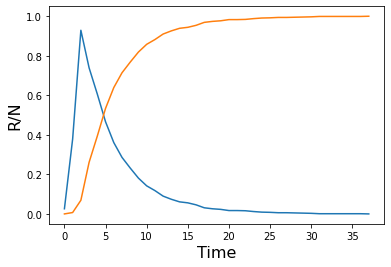

NameError: name 'my_prevalence' is not defined

In [14]:
plt.plot(my_prevalence)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('I/N', fontsize = 16)

plt.plot(my_recovered)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('R/N', fontsize = 16)
plt.xlim(0,100)

# Epidemic Threshold

In [94]:
def run_sir(G,mu,nruns):
    '''
    This function runs several realizations of the SIR dynamics for a range of values of beta 
    to create the epidemic diagram of a given graph G
    
    Arguments:
    
    G: the network 
    
    mu: recovery probability for the SIR
    
    nruns: the number of realization for each value of beta
    
    '''
    
    'to store the epidemic diagram: the betas and the average fraction of recovered at the end of the dynamics'
    beta_tot = []
    rec_tot = []
       
    'Minimum, Maximum and increase of beta'
    beta_min = 0.0
    beta_max = 0.5
    beta_step = 0.01
    
    'runs for all the values of beta in the range'
    for beta in np.arange(beta_min, beta_max, beta_step):
        
        'to store the value of rec at the end of each run, it will be used to calculate the average'
        rec = []
        
        'runs each realization of the dynamics'
        for run in range(nruns):
            
            
            susc, prev, temp_rec = sir(G, beta, mu)
            
            'since we are interested in the fraction of rec at the end of the dynamics, it only stores the last value'
            rec.append(temp_rec[-1])
        
        'calculate the mean fraction of rec over the nruns'
        rec_tot.append(np.mean(rec))
        beta_tot.append(beta/mu)
        
    
    'returns the epidemic diagram'
    return beta_tot, rec_tot

In [97]:
'Calculate the epidemic diagram for a ER graph'
N = int(1e4); p = 0.001
#beta = 0.2; mu = 0.3
mu = 0.8
G = nx.erdos_renyi_graph(N,p) # graph
#mu = 0.2 # recovery probability
nruns = 30 # number of runs 

epi_diagram_betamu, epi_diagram_rec = run_sir(G, mu, nruns)

KeyboardInterrupt: 

In [ ]:
'Plots the epidemic diagram'
def plot_func_epidthr(G,mu,fig_name, plt_title):
  plot_params(plt_title)  
  plt.title(f"{plt_title}", fontsize = 30, pad = 20)
  plt.plot(epi_diagram_beta,epi_diagram_rec,'go', label = rf"$r(\infty)$")

  plt.ylabel(rf'Final Recovered/N', fontsize = 30, labelpad = 20)
  plt.xlabel(rf'$\beta/ \mu$', fontsize = 30, labelpad = 20)

  plt.xlim(-0.01,0.4)
  #plt.ylabel('R/N', fontsize = 16)
  #plt.show()
  plt.legend(prop={'size': 18})
  plt.savefig(f"{fig_name}.jpg", format="jpg", dpi=200)
  plt.close()

plot_func_epidthr(G,mu,"ER_Epid_Threshold", "ER Epidemic Threshold")

# SIS dynamics

In [57]:
def sis(G,beta,mu,t_max):
    '''
    This functions simulates a SIR process 
    
    Arguments:
    
    1) G: the graph on which run the dynamics
    
    2) beta: per-contact probability to transmit the disease from an infected individual to a susceptible one 
    during a single time step 
    
    3) mu: probability to become recovered during a single time step
    
    4) t_max: maximum number of time-steps in the simulation
    
    Output:
    
    a list containing the prevalence during each time step
    
    '''
    'Number of nodes in the graph'
    N=G.number_of_nodes()
    
    'Creates the labels for all the individuals'
    node_labels = G.nodes()
    
    'Creates an empty list to store currently infected individuals' 
    inf_list = [] 
    
    'Creates an empty list to store the time evolution of the infected' 
    prevalence = []

    'Sets the current and future state to S for all the individuals'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
        
    'Selects the seed of the disease'
    seed = random.choice(range(N)) 

    'Sets the status of the seed to I'
    current_state[seed] = 'I'
    future_state[seed] = 'I'
    
    'Adds the seed to the infected list'
    inf_list.append(seed)
    
    
    'Temporal evolution of the dynamics, runs until t_max or there are no infected'
    for t in range(t_max): 
        
        'Infection Phase: each infected picks K individuals at random and tries to infect them'        
        for i in inf_list:
            
            'Select the neighbors of the infected node'
            tests = G.neighbors(i)

            for j in tests:

                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    
                    if random.random() < beta:
                        
                        'IMPORTANT: the status is checked on the current state but updated in the future state'
                        future_state[j] = 'I'

                    else:
                        
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state goes back to S with probability mu'        
        for i in inf_list:
            
            'Also the recovery takes place in the future state'
            if random.random() < mu:
                
                future_state[i] = 'S'
    
            else:
                 
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy()
       
        'Updates inf_list with the currently infected' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        
        'Saves the fraction of infected in the current time-step'
        prevalence.append(len(inf_list)/float(N))
        
        'If there are no more infected ends the dynamics'
        if len(inf_list) == 0:
            break
        
    return prevalence

In [58]:
G=Gba # graph
beta = 0.6 # infection probability
mu = 1.0 # recovery probability
t_max = 100 # maximum simulation time

# simulate SIS dynamics and obtain prevalence
prevalence = sis(Gba, beta, mu,t_max)

Text(0, 0.5, 'I/N')

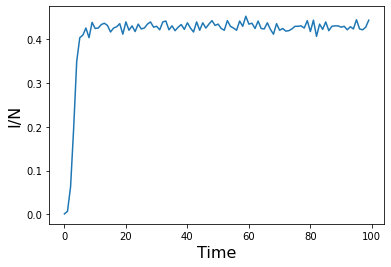

In [59]:
plt.plot(prevalence)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('I/N', fontsize = 16)

In [60]:
def run_sis(G,mu,t_max,nruns):
    '''
    This function runs several realizations of the SIS dynamics for a range of values of beta 
    to create the epidemic diagram of a given graph G
    
    Arguments:
    
    G: the network 
    
    mu: recovery probability for the SIR
    
    t_max: the maximum duration of the simulation
    
    nruns: the number of realization for each value of beta
    
    '''
    
    'to store the epidemic diagram: the betas and the average prevalence at the end of the dynamics'
    beta_tot = []
    prev_tot = []
       
    'Minimum, Maximum and increase of beta'
    beta_min = 0.0
    beta_max = 1.0
    beta_step = 0.01
    
    'runs for all the values of beta in the range'
    for beta in np.arange(beta_min, beta_max, beta_step):
        
        'to store the value of prev at the end of each run, it will be used to calculate the average'
        prev = []
    
        'runs each realization of the dynamics'
        for run in range(nruns):
            
            temp_prev = sis(G, beta, mu,t_max)
            
            'since we are interested in the fraction of rec at the end of the dynamics, it only stores the last value'
            'for the SIS it would be better to take the average of the last time steps instead of the last one'
            prev.append(temp_prev[-1])
        
        'calculate the average of the prevalance at the steady state'
        prev_tot.append(np.mean(prev))
        beta_tot.append(beta)
        
    'returns the epidemic diagram'
    return beta_tot, prev_tot

In [61]:
'Calculates the epidemic diagram for a ER graph'

G=Ger # graph
mu = 0.8 # recovery probability
nruns = 10 # number of runs 
t_max = 30 # maximum simulation time


# simulate SIS dynamics and obtain prevalence
epi_diagram_beta, epi_diagram_prev = run_sis(G, mu, t_max, nruns)


Text(0, 0.5, 'I/N')

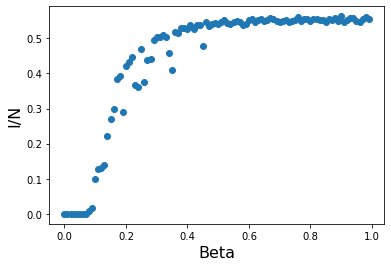

In [62]:
'Plots the epidemic diagram'

plt.plot(epi_diagram_beta,epi_diagram_prev,'o')
plt.xlabel('Beta', fontsize = 16)
plt.ylabel('I/N', fontsize = 16)